In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
import sys
import os
import json
import pandas as pd

In [59]:
def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

def PlotFEMsoluttionDict(solution):
    nodes = np.array(solution['nodes'])
    elements = np.array(solution['elements'])
    l = np.array(solution['l'])
    PlotFEMsolution(nodes, elements,l)

def PlotMesh(nodes, boundaryNodes, elements):
    plt.figure(figsize=(5,5))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k')
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()

In [404]:
data = json.load(open('TrainingData/NLheatDataset.json'))
for i in range(len(data)):
    for key in data[i].keys():
        data[i][key] = np.array(data[i][key])
    interp = CloughTocher2DInterpolator(data[i]['nodes'],data[i]['l'])
    data[i]['interp'] = interp

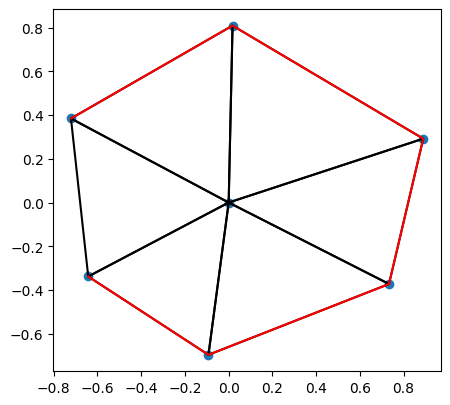

In [295]:
# sampling mechanicm
def GetAreaTriang(nodes_els):
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    return Area

def GetK(nodes_els, A):
    r = int(A.shape[0]/2)
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    B = np.concatenate([
        np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
        np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
    ],-2)/(2*Area)
    B_T = np.transpose(B,(0,2,1))
    return np.matmul(np.matmul(B_T,A),B)*Area

def GenerateTriangTrainMeshInter():
    alphas = np.linspace(0,2*np.pi,7)[:-1]-2*np.pi/3 + np.random.uniform(-np.pi/15,np.pi/15,6)
    r = np.random.uniform(0.7,1,6)
    bNodes = np.stack([np.cos(alphas)*r,np.sin(alphas)*r],axis=1)
    nodes = np.concatenate([[[0,0]],bNodes],axis=0)
    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1
    rot = np.random.uniform(0,np.pi/3)
    rot_mat = np.array([[np.cos(rot),np.sin(rot)],[-np.sin(rot),np.cos(rot)]])
    nodes = (rot_mat@nodes.T).T
    return nodes,elements

# internal training patch
nodes = data[0]['nodes']
elements = data[0]['elements']
# elSize = GetAreaTriang(nodes[elements])
elSizeSeed = 0.05 # the seed element edge size in the training patch mesh
randomGeometricScaling = 2
elSize = elSizeSeed*randomGeometricScaling**(np.random.uniform()*2-1)
nodesTP, elementsTP = GenerateTriangTrainMeshInter()
PlotMesh(nodesTP,np.arange(1,7),elementsTP)

In [296]:
np.linalg.norm(nodesTP,axis=1)

array([0.        , 0.72592634, 0.702575  , 0.822453  , 0.93645418,
       0.80932577, 0.81732321])

In [263]:
def GetShortestDist(p,b1,b2):
    v = b2-b1
    a = -v[1]
    b = v[0]
    c = v[1]*b1[0]-v[0]*b1[1]
    shortestDist = np.abs(a*p[0]+b*p[1]+c)/np.sqrt(a**2+b**2)
    return shortestDist

def GetShortestDistPolygon(point,nodesB):
    n = nodesB.shape[0]
    distances = ((point-nodesB)**2).sum(1)
    idx_closeBN = np.argmin(distances)
    idx_closeBN2 = (idx_closeBN - 1 + 2*np.argmin([distances[idx_closeBN-1], distances[(idx_closeBN+1)%n]]))%n
    # print(idx_closeBN,idx_closeBN2)
    shortestDist = GetShortestDist(point[0], nodesB[idx_closeBN], nodesB[idx_closeBN2])
    # shortestDist = np.min(distances)
    return shortestDist

# sample a random interior training patch on a given mesh
boundaryNodes = data[0]['boundaryNodes']
nodes = data[0]['nodes']
elements = data[0]['elements']
nodesB = nodes[boundaryNodes]
point = np.array([[0,0]])
distances = ((point-nodesB)**2).sum(1)
idx_closeBN = np.argmin(distances)
idx_closeBN2 = idx_closeBN - 1 + 2*np.argmin([distances[idx_closeBN-1], distances[idx_closeBN+1]])
shortestDist = GetShortestDist(point[0], nodesB[idx_closeBN], nodesB[idx_closeBN2])
shortestDist

0.46242422137161715

In [269]:
def RandomTriangSample(nodes):
    y = np.random.uniform()
    x = np.abs(np.random.uniform()-np.random.uniform())
    p = nodes[1] + (nodes[0]-nodes[1])*x - (nodes[1]-nodes[2])*(1-x)*y
    return p

def RandomMeshSample(nodes,elements):
    Area = GetAreaTriang(nodes[elements])
    el_sample = np.random.choice(np.arange(elements.shape[0]),p=Area.flatten()/Area.sum())
    point_sample = RandomTriangSample(nodes[elements[el_sample]])
    return point_sample

# nodes = np.array([[0.3,-1.1],[0.6,0.5],[-0.1,0.4]])
ps = np.zeros((5000,2))
d = np.zeros(5000)
for i in range(5000):
    # ps[i,:] = RandomTriangSample(nodes)
    ps[i,:] = RandomMeshSample(nodes,elements)
    d[i] = GetShortestDistPolygon(ps[i:i+1,:],nodes[boundaryNodes])

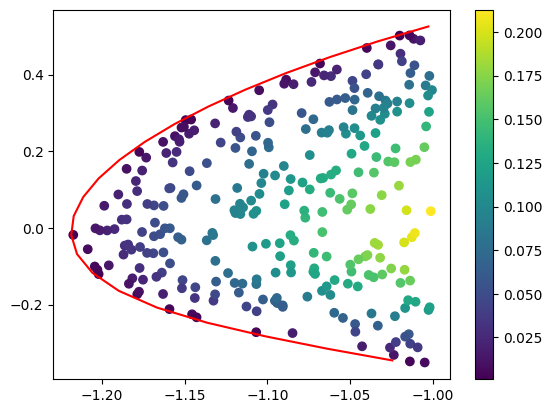

In [270]:
data = {'x':ps[:,0],'y':ps[:,1],'d':d}
df = pd.DataFrame(data)
df = df[df['x']<-1]
dataB = {'x':nodesB[:,0],'y':nodesB[:,1]}
dfB = pd.DataFrame(dataB)
dfB = dfB[dfB['x']<-1]
plt.scatter(df['x'],df['y'],c=df['d'])
plt.plot(dfB['x'],dfB['y'],'r')
plt.colorbar()
# plt.plot(nodes[:,0],nodes[:,1])

In [414]:
def GetRandomTPmesh(nodes,elements,boundaryNodes,elSizeMin=0.04,elSizeMax=0.07):
    iterations = 0
    while iterations<10:
        samplePoint = RandomMeshSample(nodes,elements)
        distance = GetShortestDistPolygon(samplePoint.reshape(1,2),nodes[boundaryNodes])
        if distance>elSizeMin:
            notesTP, elementsTP = GenerateTriangTrainMeshInter()
            nodesTP = notesTP * np.random.uniform(elSizeMin, np.min([elSizeMax,distance])) + samplePoint.reshape(1,2)
            return nodesTP, elementsTP
        iterations += 1
    return None, None

n = 1000
nodesTP_arr = np.zeros((n,7,2))
elementsTP_arr = np.zeros((n,6,3),dtype=int)
for i in range(n):
    nodesTP, elementsTP = GetRandomTPmesh(nodes, elements, boundaryNodes, elSizeMin=0.04, elSizeMax=0.07)
    nodesTP_arr[i] = nodesTP
    elementsTP_arr[i] = elementsTP

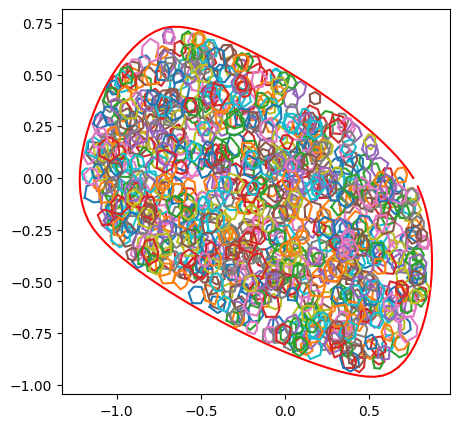

In [342]:
plt.figure(figsize=(5,5))
plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r')
for i in range(n):
    plt.plot(nodesTP_arr[i,[1,2,3,4,5,6,1],0],nodesTP_arr[i,[1,2,3,4,5,6,1],1])

In [393]:
n_r = 4
n_theta = 6
k = 0.5

alphas = np.linspace(0,2*np.pi,n_theta+1)[:-1].reshape(1,-1)
r = np.linspace(0,1,n_r+1)[1:].reshape(-1,1)
r = k*r+(1-k)*r**2
nodesIE = np.stack([r*np.cos(alphas),r*np.sin(alphas)],axis=-1)

def GetRadialEncoderInputMask(n_r,n_theta,k=0.5,Esize=0.05):
    alphas = np.linspace(0,2*np.pi,n_theta+1)[:-1].reshape(1,-1)
    r = np.linspace(0,1,n_r+1)[1:].reshape(-1,1)
    r = k*r+(1-k)*r**2
    nodesIE = np.stack([r*np.cos(alphas),r*np.sin(alphas)],axis=-1)
    nodesIE = np.concatenate([[[0,0]],nodesIE.reshape(-1,2)],axis=0)
    return nodesIE*Esize

def GetSquareEncoderInputMask(n,k=0.5,Esize=0.05):
    x = np.linspace(-1,1,2*n+1)
    x = k*x+(1-k)*x**3
    X,Y = np.meshgrid(x,x)
    nodesIE = np.stack([X,Y],axis=-1).reshape(-1,2)
    return nodesIE*Esize


nodesIE = GetRadialEncoderInputMask(6,8,0.5,0.1)
# nodesIE = GetSquareEncoderInputMask(4,0.5,0.1)

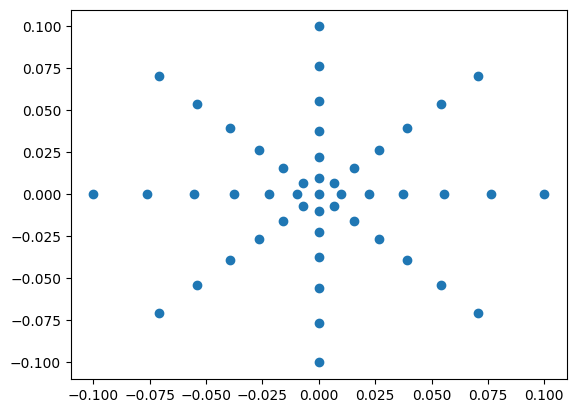

In [394]:
plt.scatter(nodesIE[:,0].flatten(),nodesIE[:,1].flatten())

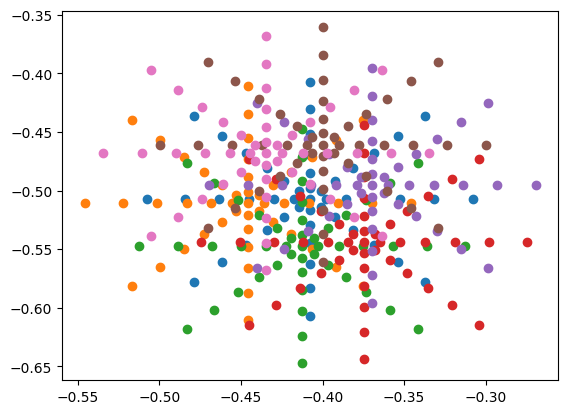

In [395]:
def GetEncoderInputTP(nodesTP,nodesIE):
    nodesTP = nodesTP.reshape(-1,1,2)
    nodesIE = nodesIE.reshape(1,-1,2)
    nodesTP_IE = nodesTP + nodesIE
    return nodesTP_IE

nodesTP_IE = GetEncoderInputTP(nodesTP,nodesIE)
for i in range(7):
    plt.scatter(nodesTP_IE[i,:,0],nodesTP_IE[i,:,1])

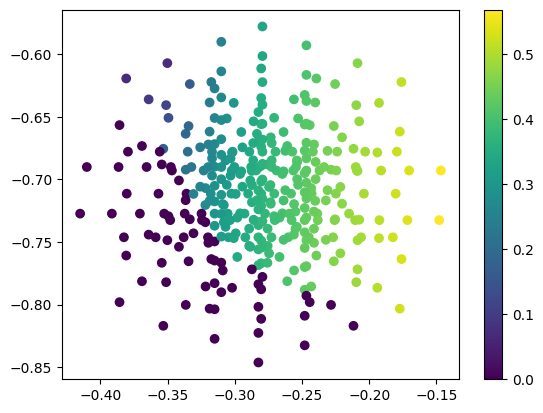

In [480]:
plt.scatter(nodesTP_IE[:,:,0].flatten(),nodesTP_IE[:,:,1].flatten(),c=uTP_IE.flatten())
plt.colorbar()

In [476]:
def GetRandomTrainingPatchInternal(data, nodesIE, elSizeMin=0.04, elSizeMax=0.07):
    idx = np.random.randint(len(data))
    nodes = data[idx]['nodes']
    elements = data[idx]['elements']
    boundaryNodes = data[idx]['boundaryNodes']
    interp = data[idx]['interp']
    nodesTP, elementsTP = GetRandomTPmesh(nodes, elements, boundaryNodes, elSizeMin=elSizeMin, elSizeMax=elSizeMax)
    nodesTP_IE = GetEncoderInputTP(nodesTP,nodesIE)
    uTP_IE = interp(nodesTP_IE)
    bTP_IE = np.isnan(uTP_IE).astype(np.float64)
    uTP_IE[np.isnan(uTP_IE)] = 0
    return nodesTP, elementsTP, uTP_IE, bTP_IE, nodesTP_IE

n = 100
nodesTP_arr = np.zeros((n,7,2))
elementsTP_arr = np.zeros((n,6,3),dtype=int)
uTP_IE_arr = np.zeros((n,7,nodesIE.shape[0],1))
bTP_IE_arr = np.zeros((n,7,nodesIE.shape[0],1))
nodesTP_IE_arr = np.zeros((n,7,nodesIE.shape[0],2))

for i in range(n):
    nodesTP, elementsTP, uTP_IE, bTP_IE, nodesTP_IE = GetRandomTrainingPatchInternal(data, nodesIE, elSizeMin=0.04, elSizeMax=0.07)
    nodesTP_arr[i] = nodesTP
    elementsTP_arr[i] = elementsTP
    uTP_IE_arr[i] = uTP_IE
    bTP_IE_arr[i] = bTP_IE
    nodesTP_IE_arr[i] = nodesTP_IE

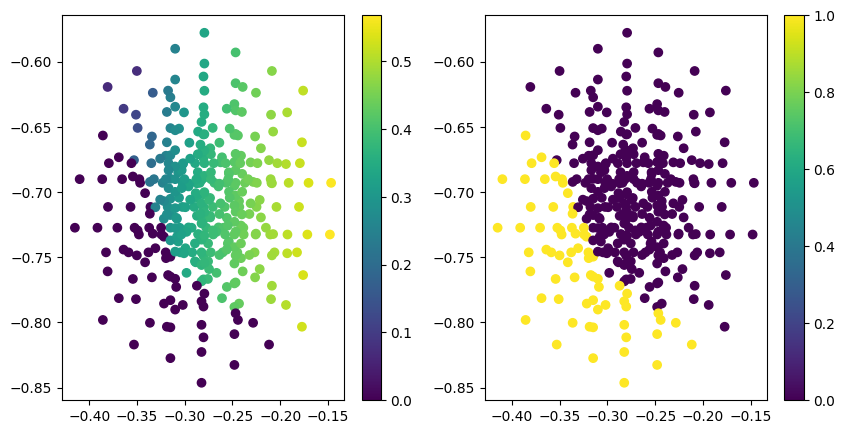

In [500]:
idxs_all = np.where(bTP_IE_arr==1)[0]
idxs = np.unique(idxs_all)
idxs_count = np.zeros(idxs.shape[0])
for i in range(idxs.shape[0]):
    idxs_count[i] = np.sum(idxs_all==idxs[i])
idx = idxs[np.argmax(idxs_count)]

uTP_IE = uTP_IE_arr[idx]
bTP_IE = bTP_IE_arr[idx]
nodesTP_IE = nodesTP_IE_arr[idx]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(nodesTP_IE[:,:,0].flatten(),nodesTP_IE[:,:,1].flatten(),c=uTP_IE.flatten())
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(nodesTP_IE[:,:,0].flatten(),nodesTP_IE[:,:,1].flatten(),c=bTP_IE.flatten())
plt.colorbar()

In [507]:
# Boundary training patch sampling

elSizeMin = 0.04
elSizeMax = 0.07

nodes = data[0]['nodes']
elements = data[0]['elements']
boundaryNodes = data[0]['boundaryNodes']
nodesB = nodes[boundaryNodes]
alpha = data[0]['alpha']

start = np.random.uniform(0,1)
elSize = np.random.uniform(elSizeMin,elSizeMax)


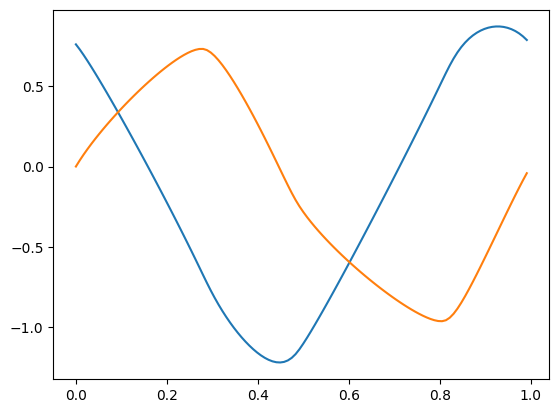

In [511]:
plt.plot(alpha,nodesB[:,0])
plt.plot(alpha,nodesB[:,1])

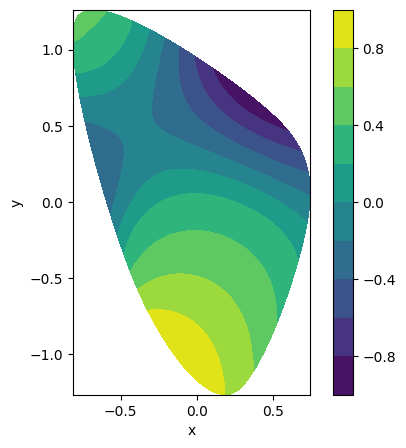

In [429]:
PlotFEMsolution(data[85]['nodes'],data[85]['elements'],data[85]['l'])

In [412]:
nodes = data[45]['nodes']
elements = data[45]['elements']

In [413]:
nodes[elements]

array([[[ 0.37312761,  0.84484979],
        [ 0.37713211,  0.79049745],
        [ 0.41721503,  0.81275919]],

       [[-0.01617885, -0.61182869],
        [ 0.04063459, -0.62600359],
        [ 0.03615744, -0.57446436]],

       [[-0.01617885, -0.61182869],
        [ 0.03615744, -0.57446436],
        [-0.01255834, -0.55759041]],

       ...,

       [[ 1.18422168,  0.04984458],
        [ 1.14389624,  0.06705699],
        [ 1.1513197 ,  0.02841289]],

       [[-0.11520027, -0.70090704],
        [-0.07725679, -0.71830095],
        [-0.08010047, -0.68193051]],

       [[ 1.10970737,  0.03628678],
        [ 1.14389624,  0.06705699],
        [ 1.10523292,  0.07786285]]])